In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.optimizers as tf_optim
tf.get_logger().setLevel('ERROR')

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import pickle
import json
import math
import datetime
import os

from sklearn.model_selection import train_test_split

fig_dpi = 200

# Neural Network Training


## Load Dataset

Read CSVs dumped from MatLab and parse into Pandas DataFrames

In [42]:
data = pd.read_csv('features.csv', header=None).T
data.columns = ['Clump thickness', 'Uniformity of cell size', 'Uniformity of cell shape', 'Marginal adhesion', 'Single epithelial cell size', 'Bare nuclei', 'Bland chomatin', 'Normal nucleoli', 'Mitoses']
labels = pd.read_csv('targets.csv', header=None).T
labels.columns = ['Benign', 'Malignant']
data.describe()

,Clump thickness,Uniformity of cell size,Uniformity of cell shape,Marginal adhesion,Single epithelial cell size,Bare nuclei,Bland chomatin,Normal nucleoli,Mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,0.441774,0.313448,0.320744,0.280687,0.321602,0.354363,0.343777,0.286695,0.158941
std,0.281574,0.305146,0.297191,0.285538,0.221430,0.360186,0.243836,0.305363,0.171508
min,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
25%,0.200000,0.100000,0.100000,0.100000,0.200000,0.100000,0.200000,0.100000,0.100000
50%,0.400000,0.100000,0.100000,0.100000,0.200000,0.100000,0.300000,0.100000,0.100000
75%,0.600000,0.500000,0.500000,0.400000,0.400000,0.500000,0.500000,0.400000,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
labels.head()

,Benign,Malignant
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0


### Explore Dataset

The classes are uneven in their occurences, stratify when splitting later on

In [5]:
labels.astype(bool).sum(axis=0)

Benign       458
Malignant    241
dtype: int64

## Split Dataset

Using a 50/50 split

In [43]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5
#                                                                     , stratify=labels
                                                                   )

## Generate & Retrieve Model

Get a shallow model with a single hidden layer of varying nodes

In [44]:
def get_model(hidden_nodes=9, activation=lambda: 'sigmoid', weight_init=lambda: 'glorot_uniform'):
    layers = [tf.keras.layers.InputLayer(input_shape=(9,), name='Input'), 
              tf.keras.layers.Dense(hidden_nodes, activation=activation(), kernel_initializer=weight_init(), name='Hidden'), 
              tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=weight_init(), name='Output')]

    model = tf.keras.models.Sequential(layers)
    return model

Get a Keras Tensorboard callback for dumping data for later analysis

In [45]:
def tensorboard_callback(path='tensorboard-logs', prefix=''):
    return tf.keras.callbacks.TensorBoard(
        log_dir=os.path.normpath(os.path.join(path, prefix + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))), histogram_freq=1
    ) 

# Example Training

## Define Model

Variable number of hidden nodes. All using 9D outputs except the last layer which is 2D for binary classification

In [60]:
model = get_model(9)
model.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 20        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


## Train Model

Example 10 epochs

In [61]:
model.fit(data_train.to_numpy(), labels_train.to_numpy(), epochs=5)

Epoch 1/5
11/11 [==============================] - 1s 2ms/step - loss: 0.6257 - accuracy: 0.6607
Epoch 2/5
11/11 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6651
Epoch 3/5
11/11 [==============================] - 0s 2ms/step - loss: 0.6326 - accuracy: 0.6424
Epoch 4/5
11/11 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6696
Epoch 5/5
11/11 [==============================] - 0s 2ms/step - loss: 0.6228 - accuracy: 0.6534


In [62]:
model.metrics_names

['loss', 'accuracy']

In [63]:
model.metrics[1].result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6561605>

# Experiment 1

The below function runs an iteration of layer/epoch investigations.
Returns the amount of layers/epochs used as well as the results and the model.

Using cancer dataset (as in E2) and 'trainscg' or an optimiser of your choice, vary nodes and epochs (that is using early stopping for epochs) over suitable range, to find optimal choice in terms of classification test error rate of node/epochs for 50/50% random train/test split (no validation set). It is suggested that you initially try epochs = [ 1 2 4 8 16 32 64], nodes = [2 8 32], so there would be 21 node/epoch combinations. 

(Hint1: from the 'advanced script' in E2, nodes can be changed to xx, with hiddenLayerSize = xx; and epochs changed to xx by addingnet. trainParam.epochs = xx; placed afternet = patternnet(hiddenLayerSize, trainFcn); --see 'trainscg' help documentation for changing epochs). 

Repeat each of the 21 node/epoch combinations at least thirty times, with different 50/50 split and take average and report classification error rate and standard deviation (std). Graph classification train and test error rate and std as node-epoch changes, that is plot error rate vs epochs for different number of nodes. Report the optimal value for test error rate and associated node/epoch values. 

(Hint2: as epochs increases you can expect the test error rate to reach a minimum and then start increasing, you may need to set the stopping criteria to achieve the desired number of epochs - Hint 3: to find classification error rates for train and test set, you need to check the code from E2, to determine how you may obtain the train and test set patterns)


In [46]:
# hidden_nodes = [2, 8, 16, 24, 32]
# epochs = [1, 2, 4, 8, 16, 32, 64, 100, 150, 200]
hidden_nodes = [2, 8, 16]
epochs = [1, 2, 4, 8]

def evaluate_parameters(hidden_nodes=hidden_nodes, 
                        epochs=epochs, 
                        batch_size=128,
                        optimizer=lambda: 'sgd',
                        weight_init=lambda: 'glorot_uniform',
                        loss=lambda: 'categorical_crossentropy',
                        metrics=['accuracy'],
                        callbacks=None,
                        validation_split=None,

                        verbose=0,
                        print_params=True,
                        return_model=True,
                        run_eagerly=False,
                        tboard=True,
                        
                        dtrain=data_train,
                        dtest=data_test,
                        ltrain=labels_train,
                        ltest=labels_test):
    for idx1, hn in enumerate(hidden_nodes):
        for idx2, e in enumerate(epochs):
            if print_params:
                print(f"Nodes: {hn}, Epochs: {e}")

            model = get_model(hn, weight_init=weight_init)
            model.compile(
                optimizer=optimizer(),
                loss=loss(),
                metrics=metrics,
                run_eagerly=run_eagerly
                )
            
            if tboard:
                if callbacks is not None:
                    cb = [i() for i in callbacks] + [tensorboard_callback(prefix=f'exp1-{hn}-{e}-')]
                else:
                    cb = [tensorboard_callback(prefix=f'exp1-{hn}-{e}-')]
            
            response = {"nodes": hn, 
                        "epochs": e,
                        ##############
                        ##   TRAIN
                        ##############
                        "history": model.fit(dtrain.to_numpy(), 
                                             ltrain.to_numpy(), 
                                             epochs=e, 
                                             verbose=verbose,
                                             
                                             callbacks=cb,
                                             validation_split=validation_split).history,
                        ##############
                        ##   TEST
                        ##############
                        "results": model.evaluate(dtest.to_numpy(), 
                                                 ltest.to_numpy(),
                                                 callbacks=cb,
                                                 batch_size=batch_size, 
                                                 verbose=verbose),
                        "optimizer": model.optimizer.get_config(),
                        "loss": model.loss,
                        "model_config": json.loads(model.to_json())
                       }

            if return_model:
                response["model"] = model

            yield response

## Single Iteration
Run a single iteration of epoch/layer investigations

In [17]:
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 5)
single_results = list(evaluate_parameters(return_model=False, validation_split=0.2
                                          , optimizer = lambda: tf.keras.optimizers.SGD(learning_rate=0.5, momentum=0.5)
#                                           , callbacks=[es]
                                         ))

Nodes: 2, Epochs: 1
Nodes: 2, Epochs: 2
Nodes: 2, Epochs: 4
Nodes: 2, Epochs: 8
Nodes: 8, Epochs: 1
Nodes: 8, Epochs: 2
Nodes: 8, Epochs: 4
Nodes: 8, Epochs: 8
Nodes: 16, Epochs: 1
Nodes: 16, Epochs: 2
Nodes: 16, Epochs: 4
Nodes: 16, Epochs: 8


### Train/Test Curves

For a single test from the set

Nodes: 2, Epochs: 4


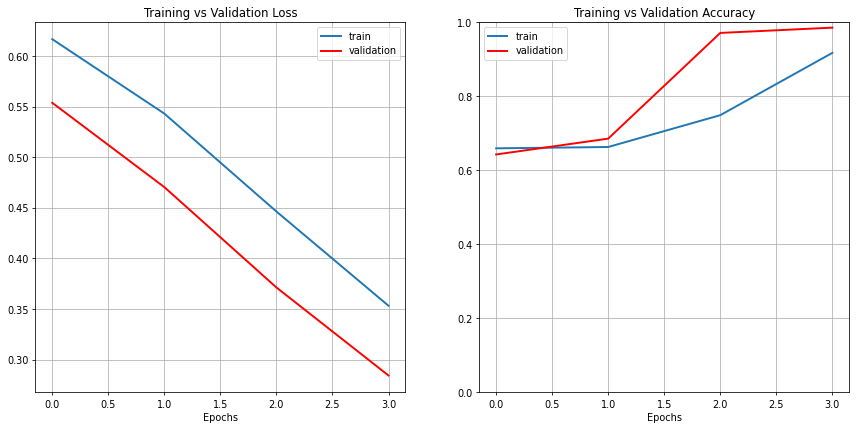

In [68]:
single_result = random.choice([i for i in single_results if i["epochs"] > 1])
single_history = single_result["history"]

fig, axes = plt.subplots(1, 2, figsize=(15,7))
fig.set_dpi(fig_dpi)

################
##    LOSS
################
ax = axes[0]
ax.set_title("Training vs Validation Loss")
ax.plot(single_history['loss'], label="train", lw=2)
ax.plot(single_history['val_loss'], label="validation", lw=2, c=(1,0,0))
ax.set_xlabel("Epochs")
ax.grid()
ax.legend()

################
##  ACCURACY
################
ax = axes[1]
ax.set_title("Training vs Validation Accuracy")
ax.plot(single_history['accuracy'], label="train", lw=2)
ax.plot(single_history['val_accuracy'], label="validation", lw=2, c=(1,0,0))
ax.set_xlabel("Epochs")
# ax.set_ylim(0, 1)
ax.grid()
ax.legend()

print(f"Nodes: {single_result['nodes']}, Epochs: {single_result['epochs']}")
# plt.tight_layout()
# plt.savefig('fig.png')
plt.show()

### Accuracy Surface

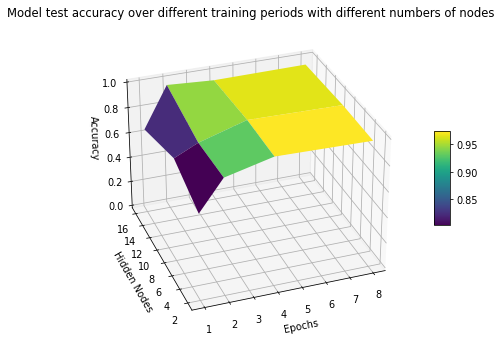

In [69]:
X, Y = np.meshgrid(epochs, hidden_nodes)

shaped_result = np.reshape([r["results"][1] for r in single_results], 
                           (len(hidden_nodes), len(epochs)))

fig = plt.figure(figsize=(8, 5))
fig.set_dpi(fig_dpi)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, shaped_result, cmap='viridis')
ax.set_title('Model test accuracy over different training periods with different numbers of nodes')
ax.set_xlabel('Epochs')
ax.set_ylabel('Hidden Nodes')
ax.set_zlabel('Accuracy')
ax.view_init(30, -110)
# ax.set_zlim([0, 1])
fig.colorbar(surf, shrink=0.3, aspect=6)

plt.tight_layout()
# plt.savefig('fig.png')
plt.show()

### Error Rate Curves

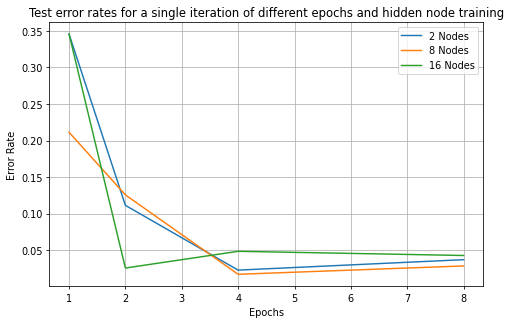

In [70]:
fig = plt.figure(figsize=(8, 5))
fig.set_dpi(fig_dpi)

for layer in hidden_nodes:
    plt.plot(epochs, 
             1 - np.array([i["results"][1] 
                  for i in single_results 
                  if i["nodes"] == layer]), 
             label=f'{layer} Nodes')

plt.legend()
plt.grid()
plt.title("Test error rates for a single iteration of different epochs and hidden node training")
plt.xlabel("Epochs")
plt.ylabel("Error Rate")
plt.ylim(0)

# plt.savefig('fig.png')
plt.show()

## Multiple Iterations

Run multiple iterations of the epoch/layer investigations and average

### CSV Results

| test | learning rate | momentum | batch size | hidden nodes | epochs |
| --- | --- | --- | --- | --- | --- |
|1|0.01|0|128|2, 8, 12, 16, 24, 32, 64, 128, 256|1, 2, 4, 8, 16, 32, 64, 100, 150, 200|
|2|0.5|0.1|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|3|0.2|0.05|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|4|0.08|0.04|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|5|0.08|0|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|
|6|0.06|0|128|1, 2, 3, 4, 5, 6, 7, 8|1, 2, 4, 8, 16, 32, 64, 100|
|7|0.06|0|35|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100|

### Pickle Results

| test | learning rate | momentum | batch size | hidden nodes | epochs | statified |
| --- | --- | --- | --- | --- | --- | --- |
|1|0.01|0|128|2, 8, 12, 16, 24, 32, 64, 128, 256|1, 2, 4, 8, 16, 32, 64, 100, 150, 200| |
|2|0.5|0.1|128|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100| |
|3|1|0.3|20|2, 8, 12, 16, 24, 32, 64, 128|1, 2, 4, 8, 16, 32, 64, 100| |
|4|0.6|0.1|20|2, 8, 16, 24, 32|1, 2, 4, 8, 16, 32, 64, 100, 150, 200| |
|5|0.05|0.01|20|2, 8, 16, 24, 32|1, 2, 4, 8, 16, 32, 64, 100, 150, 200| |
|6|1.5|0.5|20|2, 8, 16, 24, 32|1, 2, 4, 8, 16, 32, 64, 100, 150, 200| |
|2-1|0.01|0|35|2, 8, 16, 24, 32|1, 2, 4, 8, 16, 32, 64, 100, 150, 200| n |
|2-2|0.1|0|35|2, 16, 32|1, 2, 4, 8, 16, 32, 64, 100| n |
|2-3|0.15|0|35|2, 16, 32|1, 2, 4, 8, 16, 32, 64, 100| n |
|2-4|0.08|0.9|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| n |
|2-5|0.08|0.2|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| n |
|2-6|0.01|0.1|35|2, 8, 16, 24, 32|1, 2, 4, 8, 16, 32, 64, 100, 150, 200| n |
|2-7|0.01|0.9|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| n |
|2-8|0.01|0.5|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| n |
|2-9|0.01|0.3|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| n |
|2-10|0.01|0.7|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| n |
|2-11|0.01|0.0|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| n |
|2-12|0.1|0.0|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| y |
|2-13|0.5|0.0|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| y |
|2-14|0.05|0.0|35|1, 2, 8, 16, 32, 64|1, 2, 4, 8, 16, 32, 64, 100| y |

In [214]:
multi_param_results = list()
multi_iterations = 30
for i in range(multi_iterations):
    print(f"Iteration {i+1}/{multi_iterations}")
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5
#                                                                         , stratify=labels
                                                                       )
    multi_param_results.append(list(evaluate_parameters(dtrain=data_train, 
                                                  dtest=data_test, 
                                                  ltrain=labels_train, 
                                                  ltest=labels_test,
                                                  hidden_nodes=[2, 16, 32],
                                                  epochs=[1, 2, 4, 8, 16, 32, 64, 100],
                                                  optimizer=lambda: tf.keras.optimizers.SGD(learning_rate=0.15, momentum=0.0),
                                                  weight_init=lambda: 'random_uniform',
                                                  return_model=False,
                                                  print_params=False,
                                                  batch_size=35)))

Iteration 1/30
Iteration 2/30
Iteration 3/30
Iteration 4/30
Iteration 5/30
Iteration 6/30
Iteration 7/30
Iteration 8/30
Iteration 9/30
Iteration 10/30
Iteration 11/30
Iteration 12/30
Iteration 13/30
Iteration 14/30
Iteration 15/30
Iteration 16/30
Iteration 17/30
Iteration 18/30
Iteration 19/30
Iteration 20/30
Iteration 21/30
Iteration 22/30
Iteration 23/30
Iteration 24/30
Iteration 25/30
Iteration 26/30
Iteration 27/30
Iteration 28/30
Iteration 29/30
Iteration 30/30


### Accuracy Tensor

Create a tensor for holding the accuracy results

(Iterations x [Test/Train] x Number of nodes x Number of epochs)

In [165]:
multi_param_epochs = sorted(list({i["epochs"] for i in multi_param_results[0]}))
multi_param_nodes = sorted(list({i["nodes"] for i in multi_param_results[0]}))
multi_param_iter = len(multi_param_results)

accuracy_tensor = np.zeros((multi_param_iter, 2, len(multi_param_nodes), len(multi_param_epochs)))
for iter_idx, iteration in enumerate(multi_param_results):
    for single_test in iteration:
        accuracy_tensor[iter_idx, :,
                        multi_param_nodes.index(single_test['nodes']), 
                        multi_param_epochs.index(single_test['epochs'])] = [single_test["results"][1], 
                                                                            single_test["history"]["accuracy"][-1]]
        
mean_param_accuracy = np.mean(accuracy_tensor, axis=0)
std_param_accuracy = np.std(accuracy_tensor, axis=0)

print(f'{multi_param_iter} Tests')
print(f'Nodes: {multi_param_nodes}')
print(f'Epochs: {multi_param_epochs}')
print()
print(f'Loss: {multi_param_results[0][0]["loss"]}')
print(f'LR: {multi_param_results[0][0]["optimizer"]["learning_rate"]:.3}')
print(f'Momentum: {multi_param_results[0][0]["optimizer"]["momentum"]:.3}')

30 Tests
Nodes: [1, 2, 8, 16, 32, 64]
Epochs: [1, 2, 4, 8, 16, 32, 64, 100]

Loss: categorical_crossentropy
LR: 0.05
Momentum: 0.0


#### Export/Import Test Sets

Export mean and standard deviations for retrieval and visualisation 

In [215]:
pickle.dump(multi_param_results, open("results/exp1-test2-3.p", "wb"))

In [164]:
exp1_testname = 'exp1-test2-14'
multi_param_results = pickle.load(open(f"results/{exp1_testname}.p", "rb"))

### Best Results

In [166]:
best_param_accuracy_idx = np.unravel_index(np.argmax(mean_param_accuracy[0, :, :]), mean_param_accuracy.shape)
best_param_accuracy = mean_param_accuracy[best_param_accuracy_idx]
best_param_accuracy_nodes = multi_param_nodes[best_param_accuracy_idx[1]]
best_param_accuracy_epochs = multi_param_epochs[best_param_accuracy_idx[2]]

print(f'Nodes: {best_param_accuracy_nodes}, Epochs: {best_param_accuracy_epochs}, {best_param_accuracy * 100:.3}% Accurate')

Nodes: 32, Epochs: 100, 96.1% Accurate


### Test Accuracy Surface

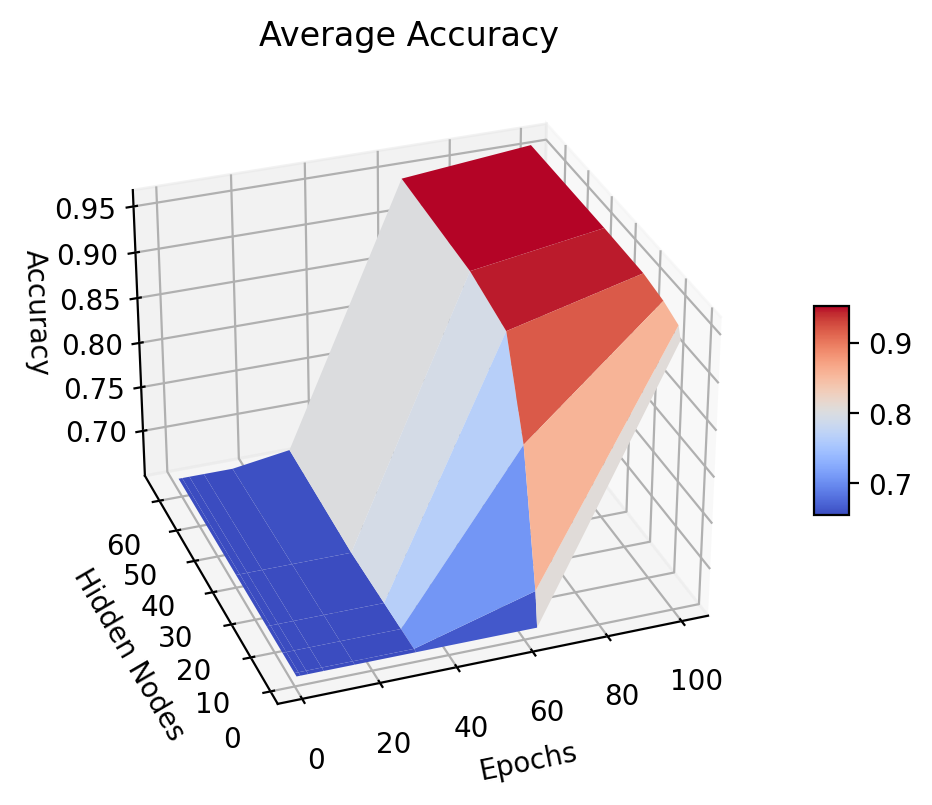

In [167]:
X, Y = np.meshgrid(multi_param_epochs, multi_param_nodes)

# fig = plt.figure(figsize=(10, 5))
fig = plt.figure()
fig.set_dpi(fig_dpi)
ax = plt.axes(projection='3d')

surf = ax.plot_surface(X, Y, mean_param_accuracy[0, :, :], cmap='coolwarm')
ax.set_title(f'Average Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Hidden Nodes')
ax.set_zlabel('Accuracy')
ax.view_init(30, -110)
# ax.set_zlim([0, 1])
fig.colorbar(surf, shrink=0.3, aspect=6)

plt.tight_layout()
# plt.savefig(f'graphs/{exp1_testname}-acc-surf.png')
plt.show()

### Test Error Rate Curves

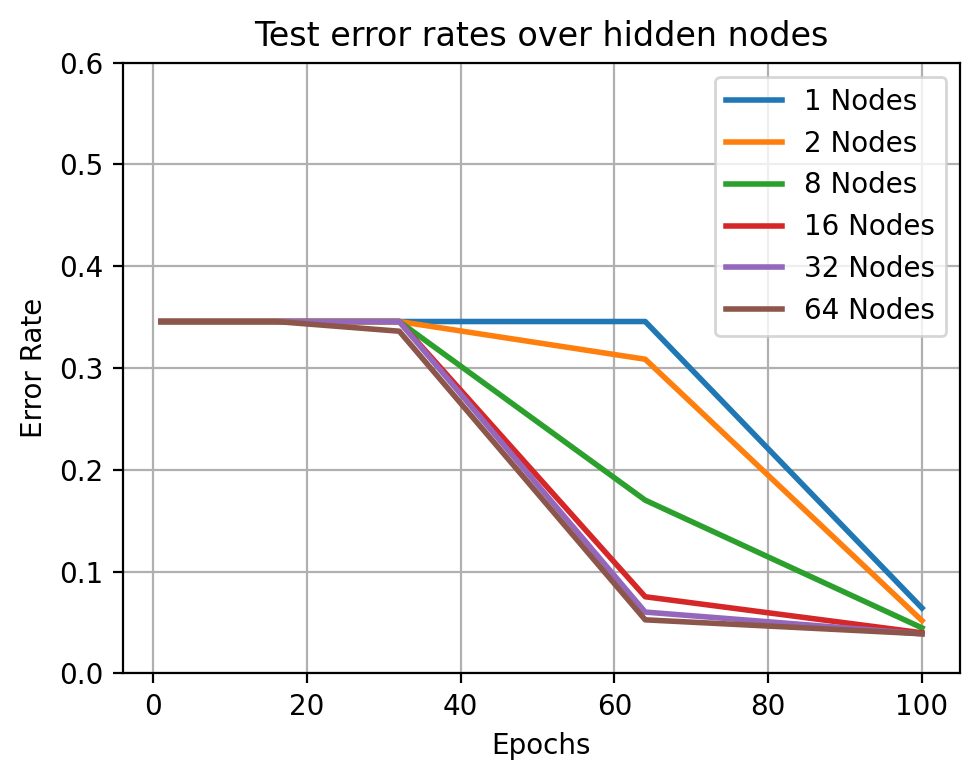

In [168]:
fig = plt.figure(figsize=(5, 4))
# fig = plt.figure()
fig.set_dpi(fig_dpi)

for idx, (layer, std) in enumerate(zip(mean_param_accuracy[0, :, :], std_param_accuracy[0, :, :])):
#     plt.errorbar(multi_param_epochs, 1 - layer, yerr=std, capsize=4, label=f'{multi_param_nodes[idx]} Nodes')
    plt.plot(multi_param_epochs, 1 - layer, '-', label=f'{multi_param_nodes[idx]} Nodes', lw=2)

plt.legend()
plt.grid()
plt.title(f"Test error rates over hidden nodes")
plt.xlabel("Epochs")
plt.ylabel("Error Rate")
plt.ylim(0, 0.6)

plt.tight_layout()
plt.savefig(f'graphs/{exp1_testname}-error-rate-curves.png')
plt.show()

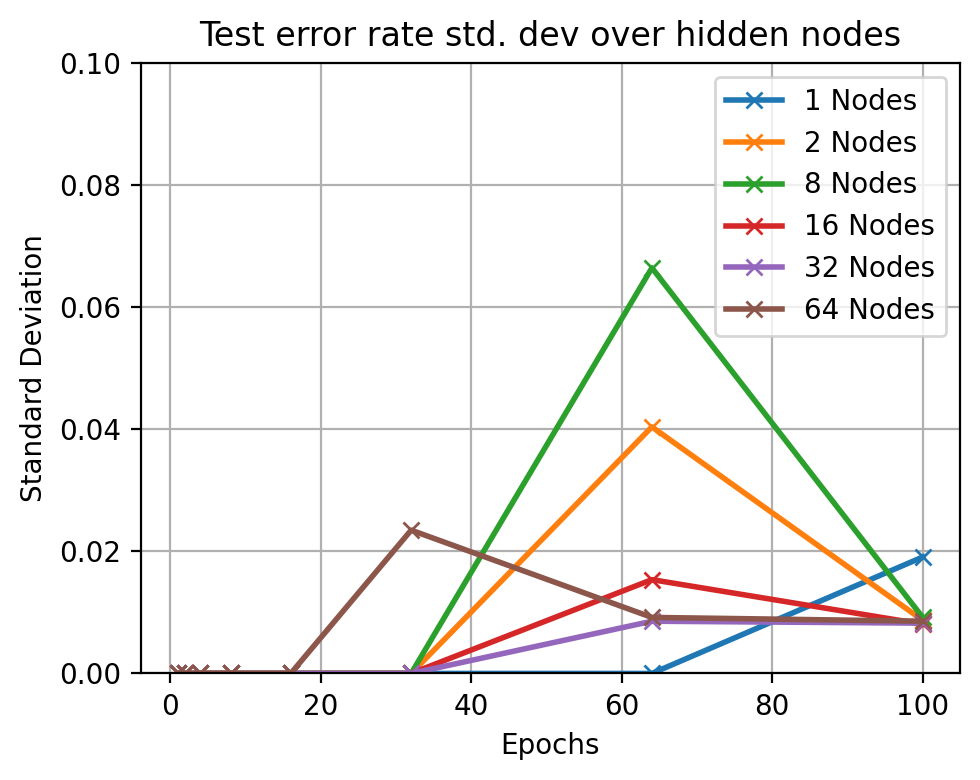

In [172]:
fig = plt.figure(figsize=(5, 4))
# fig = plt.figure()
fig.set_dpi(fig_dpi)

for idx, (layer, std) in enumerate(zip(mean_param_accuracy[0, :, :], std_param_accuracy[0, :, :])):
#     plt.errorbar(multi_param_epochs, 1 - layer, yerr=std, capsize=4, label=f'{multi_param_nodes[idx]} Nodes')
    plt.plot(multi_param_epochs, std, 'x-', label=f'{multi_param_nodes[idx]} Nodes', lw=2)

plt.legend()
plt.grid()
plt.title(f"Test error rate std. dev over hidden nodes")
plt.xlabel("Epochs")
plt.ylabel("Standard Deviation")
plt.ylim(0, 0.1)

plt.tight_layout()
plt.savefig(f'graphs/{exp1_testname}-error-rate-std.png')
plt.show()

### Test/Train Error Over Nodes

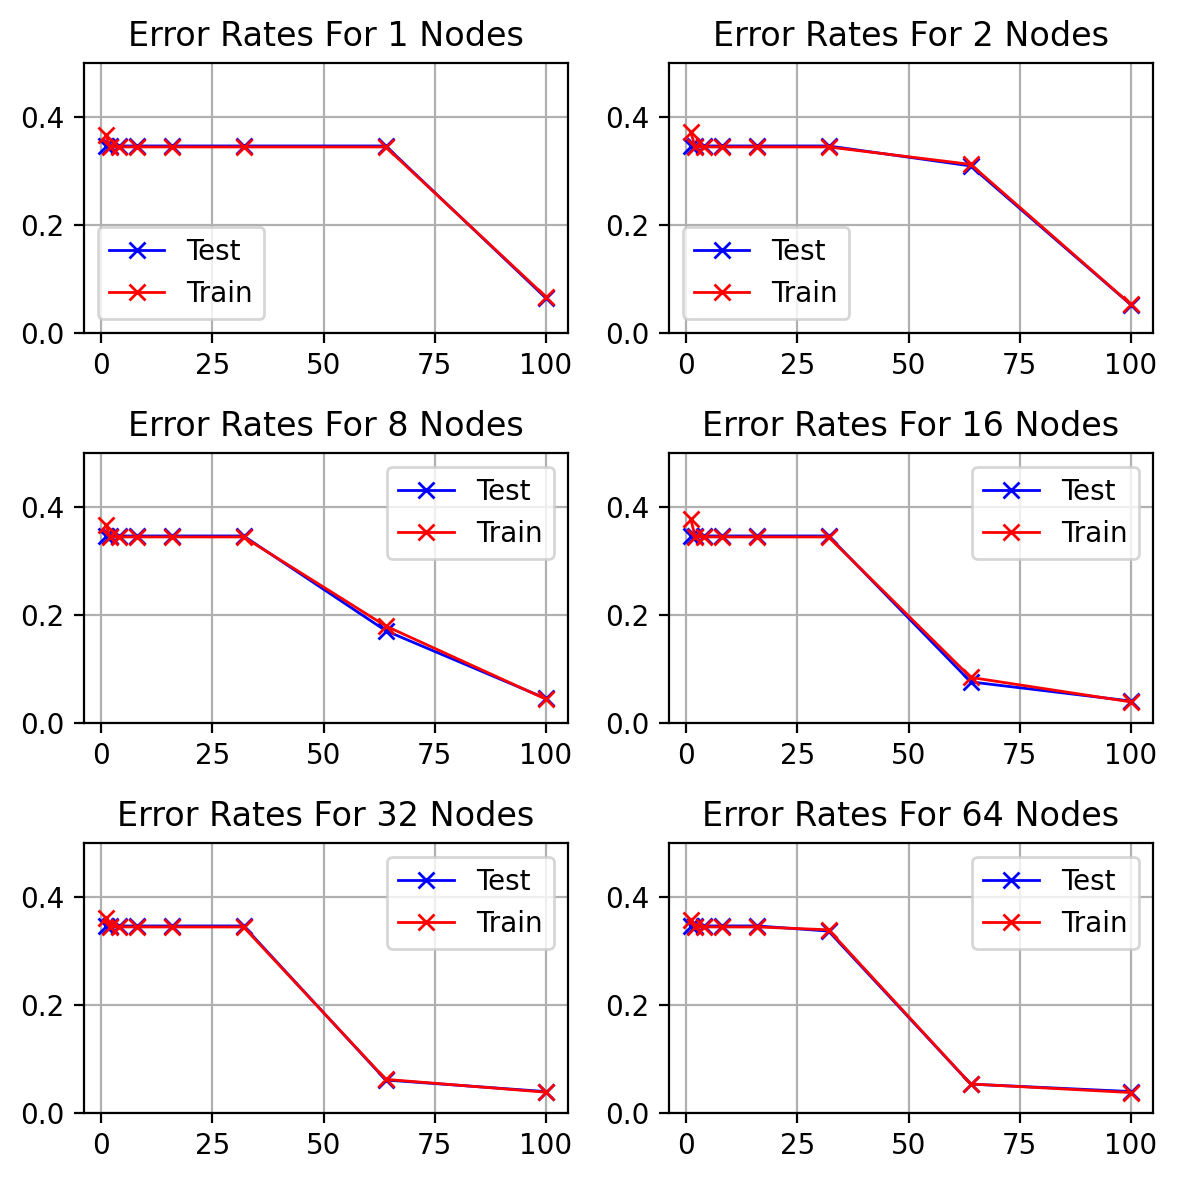

In [170]:
fig, axes = plt.subplots(math.ceil(len(multi_param_nodes) / 2), 2, figsize=(6, 6*math.ceil(len(multi_param_nodes) / 2)/3))
fig.set_dpi(fig_dpi)

for idx, (nodes, ax) in enumerate(zip(multi_param_nodes, axes.flatten())):
    ax.set_title(f'Error Rates For {nodes} Nodes')
#     ax.errorbar(multi_param_epochs, 1 - mean_param_accuracy[0, idx, :], fmt='x', ls='-', yerr=std_param_accuracy[0, idx, :], markersize=4, lw=1, label='Test', capsize=4, c=(0, 0, 1), ecolor=(0, 0, 1, 0.5))
#     ax.errorbar(multi_param_epochs, 1 - mean_param_accuracy[1, idx, :], fmt='x', ls='-', yerr=std_param_accuracy[1, idx, :], markersize=4, lw=1, label='Train', capsize=4, c=(1, 0, 0), ecolor=(1, 0, 0, 0.5))
    ax.plot(multi_param_epochs, 1 - mean_param_accuracy[0, idx, :], 'x', ls='-', lw=1, label='Test', c=(0, 0, 1))
    ax.plot(multi_param_epochs, 1 - mean_param_accuracy[1, idx, :], 'x', ls='-', lw=1, label='Train', c=(1, 0, 0))
    ax.set_ylim(0, np.round(np.max(1 - mean_param_accuracy + std_param_accuracy) + 0.05, 1))
    ax.legend()
    ax.grid()

fig.tight_layout()
fig.savefig(f'graphs/{exp1_testname}-test-train-error-rate.png')

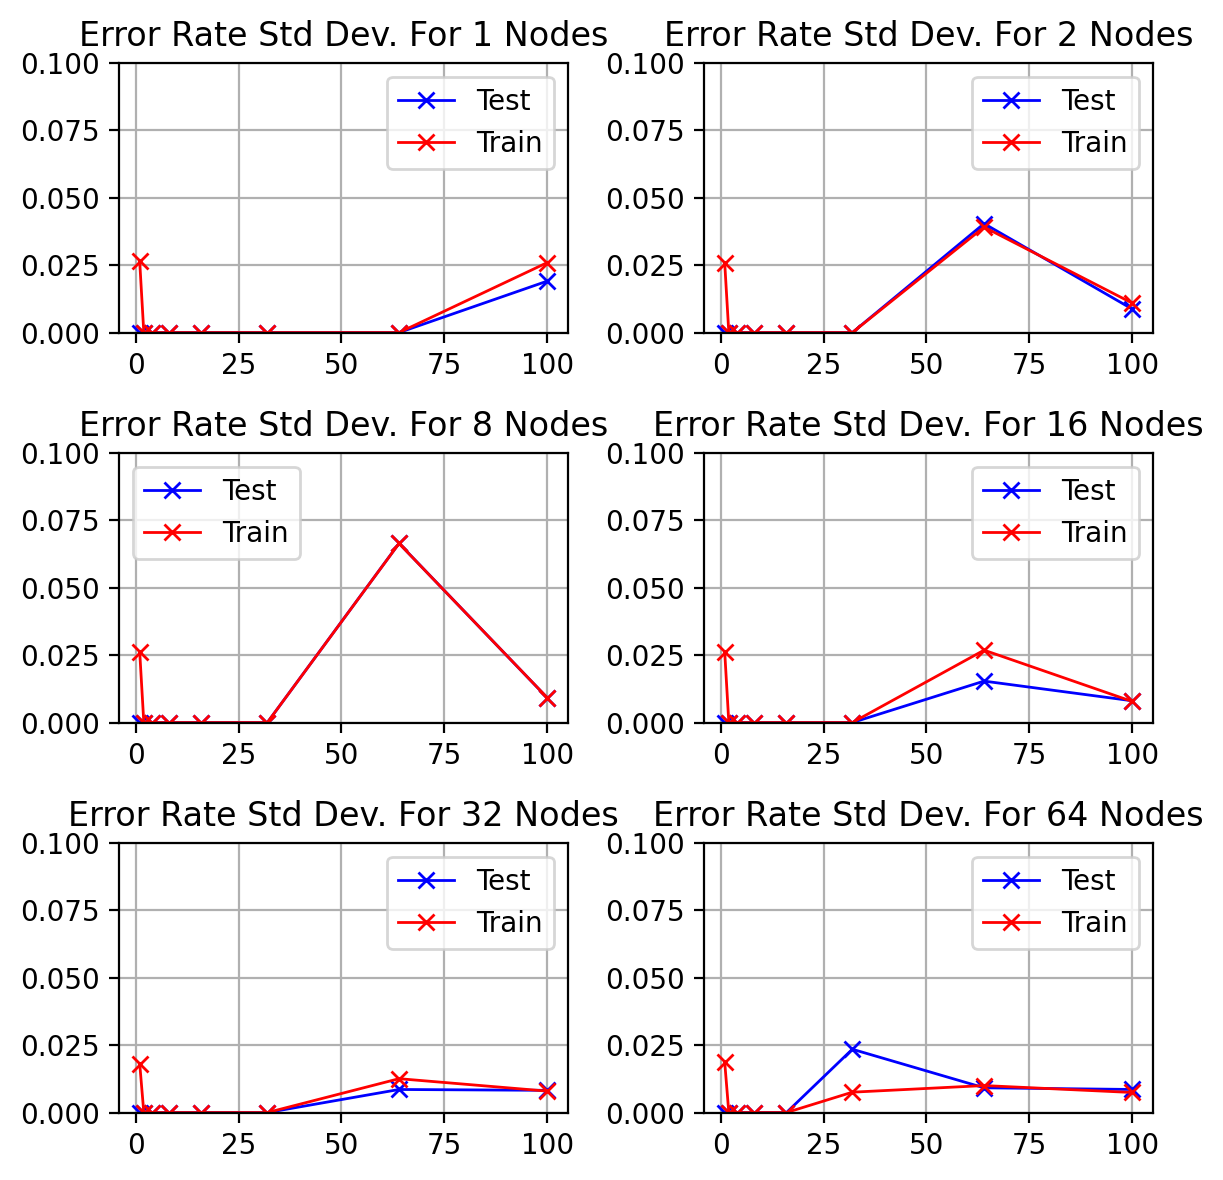

In [171]:
fig, axes = plt.subplots(math.ceil(len(multi_param_nodes) / 2), 2, figsize=(6, 6*math.ceil(len(multi_param_nodes) / 2)/3))
fig.set_dpi(fig_dpi)

for idx, (nodes, ax) in enumerate(zip(multi_param_nodes, axes.flatten())):
    ax.set_title(f'Error Rate Std Dev. For {nodes} Nodes')
    ax.plot(multi_param_epochs, std_param_accuracy[0, idx, :], 'x', ls='-', lw=1, label='Test', c=(0, 0, 1))
    ax.plot(multi_param_epochs, std_param_accuracy[1, idx, :], 'x', ls='-', lw=1, label='Train', c=(1, 0, 0))
    ax.set_ylim(0, np.round(np.max(std_param_accuracy) + 0.05, 1))
    ax.legend()
    ax.grid()

fig.tight_layout()
fig.savefig(f'graphs/{exp1_testname}-test-train-error-rate-std.png')

# Experiment 2

For cancer dataset, choose an appropriate value of node and epochs, based on Exp 1) and use ensemble of individual (base) classifiers with random starting weights and Majority Vote to see if performance improves - repeat the majority vote ensemble at least thirty times with different 50/50 split and average and graph (Each classifier in the ensemble sees the same training patterns). Repeat for a different odd number (prevents tied vote) of individual classifiers between 3 and 25, and comment on the result of individualclassifier accuracy vs ensemble accuracy as number of base classifiers varies. Consider changing the number of nodes/epochs (both less complex and more complex) to see if you obtain better performance, and comment on the result with respect to why the optimal node/epoch combination may be different for an ensemble compared with the base classifier, as in Exp 1). 

(Hint4: to implement majority vote you need to determine the predicted class labels -probably easier to implement yourself rather than use the ensemble matlab functions)


In [243]:
num_models=[1, 3, 9, 15, 25]

def evaluate_ensemble_vote(hidden_nodes=16, 
                           epochs=50, 
                           batch_size=128,
                           learning_rates=None,
                           optimizer=lambda: 'sgd',
                           weight_init=lambda: 'glorot_uniform',
                           loss=lambda: 'categorical_crossentropy',
                           metrics=['accuracy'],
                           callbacks=None,
                           validation_split=None,
                           round_predictions=True,

                           nmodels=num_models,
                           tboard=True,
                           exp='2',

                           verbose=0,
                           print_params=True,
                           return_model=True,

                           dtrain=data_train,
                           dtest=data_test,
                           ltrain=labels_train,
                           ltest=labels_test):
    
    for m in nmodels: # iterate over different ensemble sizes
        if print_params:
            print(f"Models: {m}")
            
        # response dict object for test stats
        response = {"epochs": list(),
                    "num_models": m}
            
        ###################
        ##   GET MODELS
        ###################
        if isinstance(hidden_nodes, tuple): # for range of hidden nodes, calculate value per model
            if m == 1:
                # just average provided range
                models = [get_model(int(np.mean(hidden_nodes)), weight_init=weight_init)]
                response["nodes"] = [int(np.mean(hidden_nodes))]
                
            else:
                # use linspace to generate equally spaced nodes throughout range
                models = [get_model(int(i), weight_init=weight_init) 
                          for i in np.linspace(*hidden_nodes, num=m)]
                response["nodes"] = [int(i) for i in np.linspace(*hidden_nodes, num=m)]
        
        elif hidden_nodes == 'm':
            # incrementing mode, number of nodes ranges from 1 to m
            # more nodes in larger ensembles
            models = [get_model(i+1, weight_init=weight_init) for i in range(m)]
            response["nodes"] = [i+1 for i in range(m)]
        else: 
            # not a range of epochs, just set to given value
            models = [get_model(hidden_nodes, weight_init=weight_init) for _ in range(m)]
            response["nodes"] = hidden_nodes

        ######################
        ##   COMPILE MODELS
        ######################
        if learning_rates is None:
            # default, use provided optimiser
            for model in models:        
                model.compile(
                    optimizer=optimizer(),
                    loss=loss(),
                    metrics=metrics
                    )     
        else:
            # ignore provided optimiser, use SGD with a range of learning rates
            if isinstance(learning_rates, tuple):
                lr_range = np.linspace(*learning_rates, num=m)
            elif learning_rates == '+':
                # incrementing mode, scale with size of ensemble
                lr_range = [0.01 * (i + 1) for i in range(m)]
                
            for model, lr in zip(models, lr_range):        
                model.compile(
                    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
                    loss=loss(),
                    metrics=metrics
                    )
        
        if tboard:
            if callbacks is not None:
                cb = [i() for i in callbacks] + [tensorboard_callback(prefix=f'exp{exp}-{m}-')]
            else:
                cb = [tensorboard_callback(prefix=f'exp{exp}-{m}-')]
        
        ###################
        ##  TRAIN MODELS
        ###################
        histories = list()
        for idx, model in enumerate(models):
            if isinstance(epochs, tuple): # for range of epochs, calculate value per model
                if m == 1:
                    e = np.mean(epochs) # average, not lower bound if single model
                else:
                    e = np.linspace(*epochs, num=m)[idx]
                e = int(e)
            else: # not a range of epochs, just set to given value
                e = epochs
                
#             print(m, e) # debug
            
            history = model.fit(dtrain.to_numpy(), 
                                ltrain.to_numpy(), 
                                epochs=e, 
                                verbose=verbose,

                                callbacks=cb,
                                validation_split=validation_split)
            histories.append(history.history)
            response["epochs"].append(e)

        ############################
        ##  FEEDFORWARD TEST DATA
        ############################
        # TEST DATA PREDICTIONS
        response["predictions"] = [model(dtest.to_numpy()) for model in models]
        # TEST LABEL TENSOR
        ltest_tensor = tf.constant(ltest.to_numpy())

        ########################
        ##  ENSEMBLE ACCURACY
        ########################
        ensem_sum_rounded = sum(tf.math.round(pred) for pred in response["predictions"])
        ensem_sum = sum(response["predictions"])
        # round predictions to onehot vectors and sum over all ensemble models
        # take argmax for ensemble predicted class
        
        correct = 0 # number of correct ensemble predictions
        correct_num_models = 0 # when correctly predicted ensembley, number of models correctly classifying
        individual_accuracy = 0 # proportion of models correctly classifying
        
         # pc = predicted class, pcr = rounded predicted class, gt = ground truth
        for pc, pcr, gt in zip(ensem_sum, ensem_sum_rounded, ltest_tensor):
            gt_argmax = tf.math.argmax(gt)
            
            if round_predictions:
                pred_val = pcr
            else:
                pred_val = pc
            
            correct_models = pcr[gt_argmax] / m # use rounded value so will divide nicely
            individual_accuracy += correct_models
            
            if tf.math.argmax(pred_val) == gt_argmax: # ENSEMBLE EVALUATE HERE
                correct += 1
                correct_num_models += correct_models
                
#                 print(pc.numpy(), pcr.numpy(), gt.numpy(), (pcr[gt_argmax] / m).numpy(), True) # debug
#             else:
#                 print(pc.numpy(), pcr.numpy(), gt.numpy(), (pcr[gt_argmax] / m).numpy(), False)
                
        ########################
        ##      RESULTS
        ########################
        response.update({
            "history": histories,
            "optimizer": model.optimizer.get_config(),
            "model_config": json.loads(model.to_json()),
            "loss": model.loss,
            "round_predictions": round_predictions,
            
            "accuracy": correct / len(ltest), # average number of correct ensemble predictions
            "agreement": correct_num_models / correct, # when correctly predicted ensembley, average proportion of models correctly classifying
            "individual_accuracy": individual_accuracy / len(ltest) # average proportion of individual models correctly classifying
        })

        if return_model:
            response["models"] = models

        yield response

## Single Iteration
Run a single iteration of ensemble model investigations

In [246]:
single_ensem_results = list()
# for test in evaluate_ensemble_vote(epochs=(5, 300), optimizer=lambda: tf.keras.optimizers.SGD(learning_rate=0.02)):
for test in evaluate_ensemble_vote(hidden_nodes=20,
                                   epochs=30,
                                   learning_rates=(0.01, 0.5),
                                   optimizer=lambda: tf.keras.optimizers.SGD(learning_rate=0.02)):
    single_ensem_results.append(test)
    print(test["nodes"], test["epochs"])

Models: 1
20 [30]
Models: 3
20 [30, 30, 30]
Models: 9
20 [30, 30, 30, 30, 30, 30, 30, 30, 30]
Models: 15
20 [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Models: 25
20 [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


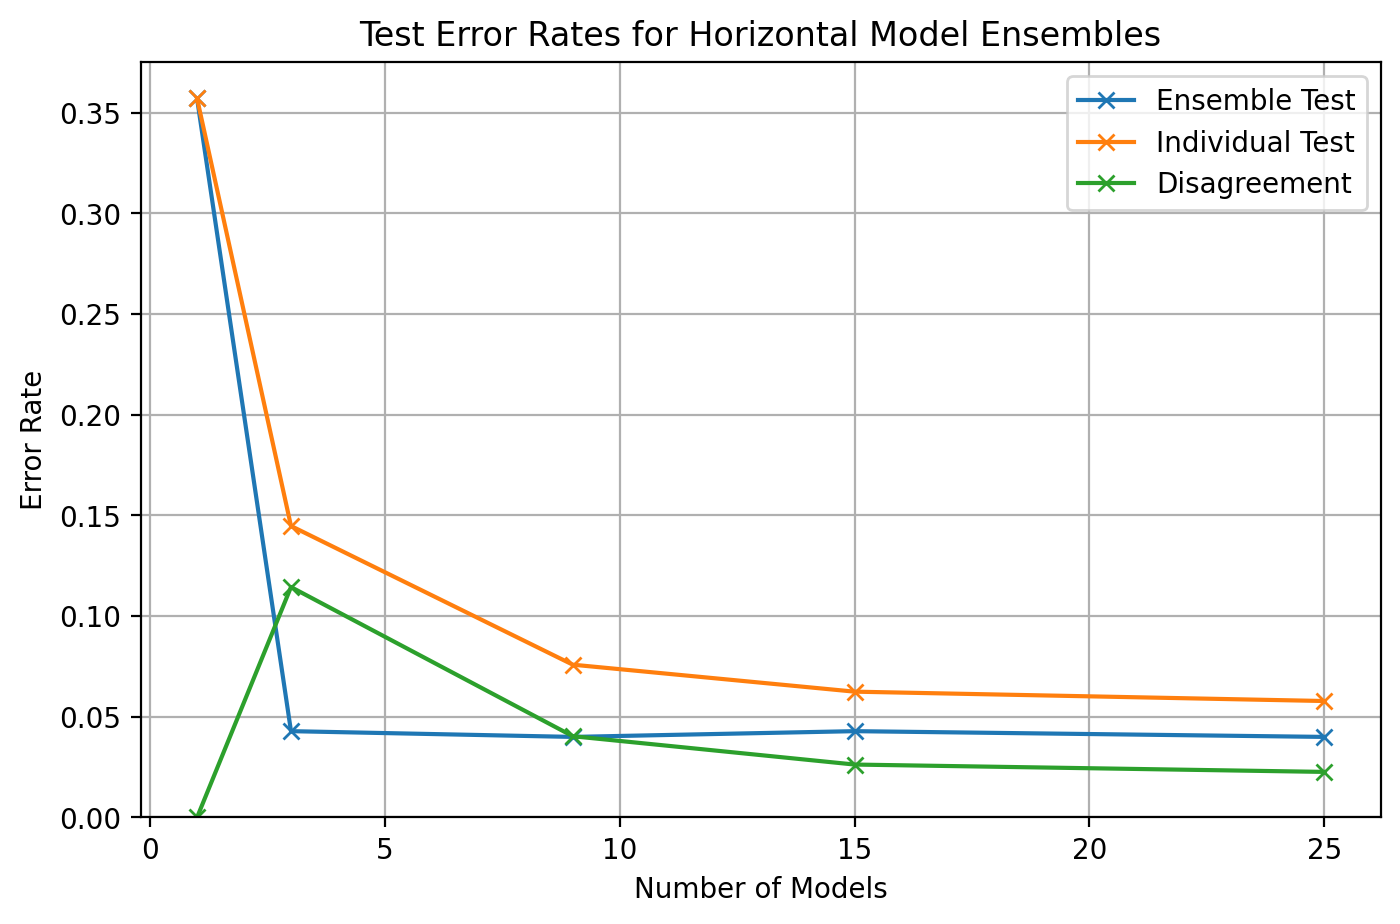

In [247]:
fig = plt.figure(figsize=(8, 5))
fig.set_dpi(fig_dpi)

ensem_x = [i["num_models"] for i in single_ensem_results]

plt.plot(ensem_x, 1 - np.array([i["accuracy"] for i in single_ensem_results]), 'x-', label='Ensemble Test')
plt.plot(ensem_x, 1 - np.array([i["individual_accuracy"] for i in single_ensem_results]), 'x-', label='Individual Test')
plt.plot(ensem_x, 1 - np.array([i["agreement"] for i in single_ensem_results]), 'x-', label='Disagreement')

plt.title("Test Error Rates for Horizontal Model Ensembles")
plt.ylim(0)
plt.grid()
plt.legend()
plt.ylabel("Error Rate")
plt.xlabel("Number of Models")
plt.show()

## Multiple Iterations
Run multiple iterations of the ensemble model investigations and average

### CSV Results

| test | learning rate | momentum | batch size | hidden nodes | epochs | models |
| --- | --- | --- | --- | --- | --- | --- |
|1|0.06|0|128|16|50|1, 3, 9, 15, 25|
|2|0.06|0|35|16|1 - 100|1, 3, 9, 15, 25|

### Pickle Results

| test | learning rate | momentum | batch size | hidden nodes | epochs | models | stratify |
| --- | --- | --- | --- | --- | --- | --- | --- |
|3|0.06|0.05|35|16|1 - 300|1, 3, 9, 15, 25| |
|4|0.06|0.05|35|1 - 50|50|1, 3, 9, 15, 25| |
|5|0.06|0.05|35|1 - 300|50|1, 3, 9, 15, 25| |
|6|0.001|0.01|35|1 - 400|50|1, 3, 9, 15, 25| |
|7|0.01|0.01|35|1 - 400|30 - 150|1, 3, 9, 15, 25| |
|8|0.03|0.01|35|1 - 400|5 - 100|1, 3, 9, 15, 25| |
|9|0.1|0.01|35|1 - 400|20|1, 3, 9, 15, 25| |
|10|0.15|0.01|35|1 - 400|20|1, 3, 9, 15, 25, 35, 45| |
|11|0.15|0.01|35|1 - 400|10|1, 3, 9, 15, 25, 35, 45| |
|12|0.02|0.01|35|m|50|1, 3, 9, 15, 25, 35, 45| |
|13|0.01 exp 0.98, 1|0.01|35|1 - 200|50|1, 3, 9, 15, 25, 35, 45| n |
|14|0.01|0.01|35|1 - 200|50|1, 3, 9, 15, 25, 35, 45| n |
|15|0.01|0.9|35|50 - 100|50|1, 3, 5, 7, 9, 15, 25, 35, 45| n |
|16|0.01|0.1|35|50 - 100|50|1, 3, 5, 7, 9, 15, 25, 35, 45| n |
|17|0.1|0.1|35|50 - 100|50 - 100|1, 3, 5, 7, 9, 15, 25, 35, 45| n |

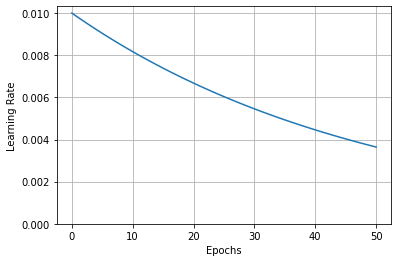

In [335]:
batch_size=35
test_size=0.5
epochs=50
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01,
                                                             decay_steps=1,
                                                             decay_rate=0.98)

plt.plot(range(epochs+1), [lr_schedule(i) for i in range(epochs+1)])
plt.grid()
plt.ylim(0)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()

In [357]:
multi_ensem_results = list()
multi_ensem_iterations = 30
for i in range(multi_ensem_iterations):
    print(f"Iteration {i+1}/{multi_ensem_iterations}")
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_size, 
#                                                                         stratify=labels
                                                                       )
    multi_ensem_results.append(list(evaluate_ensemble_vote(epochs=(50, 100),
                                                           hidden_nodes=(50, 100),
                                                           nmodels=[1, 3, 5, 7, 9, 15, 25, 35, 45],
                                                           optimizer=lambda: tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.1),
                                                           weight_init=lambda: 'random_uniform',
                                                           batch_size=batch_size,
                                                           dtrain=data_train, 
                                                           dtest=data_test, 
                                                           ltrain=labels_train, 
                                                           ltest=labels_test,
                                                           return_model=False,
                                                           print_params=False)))

Iteration 1/30
Iteration 2/30
Iteration 3/30
Iteration 4/30
Iteration 5/30
Iteration 6/30
Iteration 7/30
Iteration 8/30
Iteration 9/30
Iteration 10/30
Iteration 11/30
Iteration 12/30
Iteration 13/30
Iteration 14/30
Iteration 15/30
Iteration 16/30
Iteration 17/30
Iteration 18/30
Iteration 19/30
Iteration 20/30
Iteration 21/30
Iteration 22/30
Iteration 23/30
Iteration 24/30
Iteration 25/30
Iteration 26/30
Iteration 27/30
Iteration 28/30
Iteration 29/30
Iteration 30/30


### Accuracy Tensor

Create a tensor for holding the accuracy results

(Iterations x Param x Number of models)

#### Params
0. Test Accuracy
1. Train Accuracy
2. Individual Accuracy
3. Agreement

In [173]:
def test_tensor_data(test):
    return [test["accuracy"], 
            np.mean([i["accuracy"][-1] for i in test["history"]]), # avg train acc
            test["individual_accuracy"], 
            test["agreement"]]

In [235]:
multi_ensem_models = sorted(list({i["num_models"] for i in multi_ensem_results[0]}))
multi_ensem_iter = len(multi_ensem_results)

accuracy_ensem_tensor = np.zeros((multi_ensem_iter, 4, len(multi_ensem_models)))
for iter_idx, iteration in enumerate(multi_ensem_results):
    for single_test in iteration:
        
        ensem_models_idx = multi_ensem_models.index(single_test['num_models'])
        accuracy_ensem_tensor[iter_idx, :, ensem_models_idx] = test_tensor_data(single_test)
        
mean_ensem_accuracy = np.mean(accuracy_ensem_tensor, axis=0)
std_ensem_accuracy = np.std(accuracy_ensem_tensor, axis=0)

print(f'{multi_ensem_iter} Tests')
print(f'Models: {multi_ensem_models}')
print()
print(f'Loss: {multi_ensem_results[0][0]["loss"]}')
print(f'LR: {multi_ensem_results[0][0]["optimizer"]["learning_rate"]:.3}')
print(f'Momentum: {multi_ensem_results[0][0]["optimizer"]["momentum"]:.3}')

30 Tests
Models: [1, 3, 5, 7, 9, 15, 25, 35, 45]

Loss: categorical_crossentropy
LR: 0.1
Momentum: 0.1


#### Export/Import Test Sets

Export mean and standard deviations for retrieval and visualisation 

In [358]:
exp2_testname = 'exp2-test17'
pickle.dump(multi_ensem_results, open(f"results/{exp2_testname}.p", "wb"))

In [240]:
exp2_testname = 'exp2-test16'
multi_ensem_results = pickle.load(open(f"results/{exp2_testname}.p", "rb"))

### Best Results

In [236]:
best_ensem_accuracy_idx = np.unravel_index(np.argmax(mean_ensem_accuracy[0, :]), mean_ensem_accuracy.shape)
best_ensem_accuracy = mean_ensem_accuracy[best_ensem_accuracy_idx]
best_ensem_accuracy_models = multi_ensem_models[best_ensem_accuracy_idx[1]]

print(f'Models: {best_ensem_accuracy_models}, {best_ensem_accuracy * 100:.3}% Accurate')

Models: 5, 96.4% Accurate


### Test/Train Error Over Model Numbers

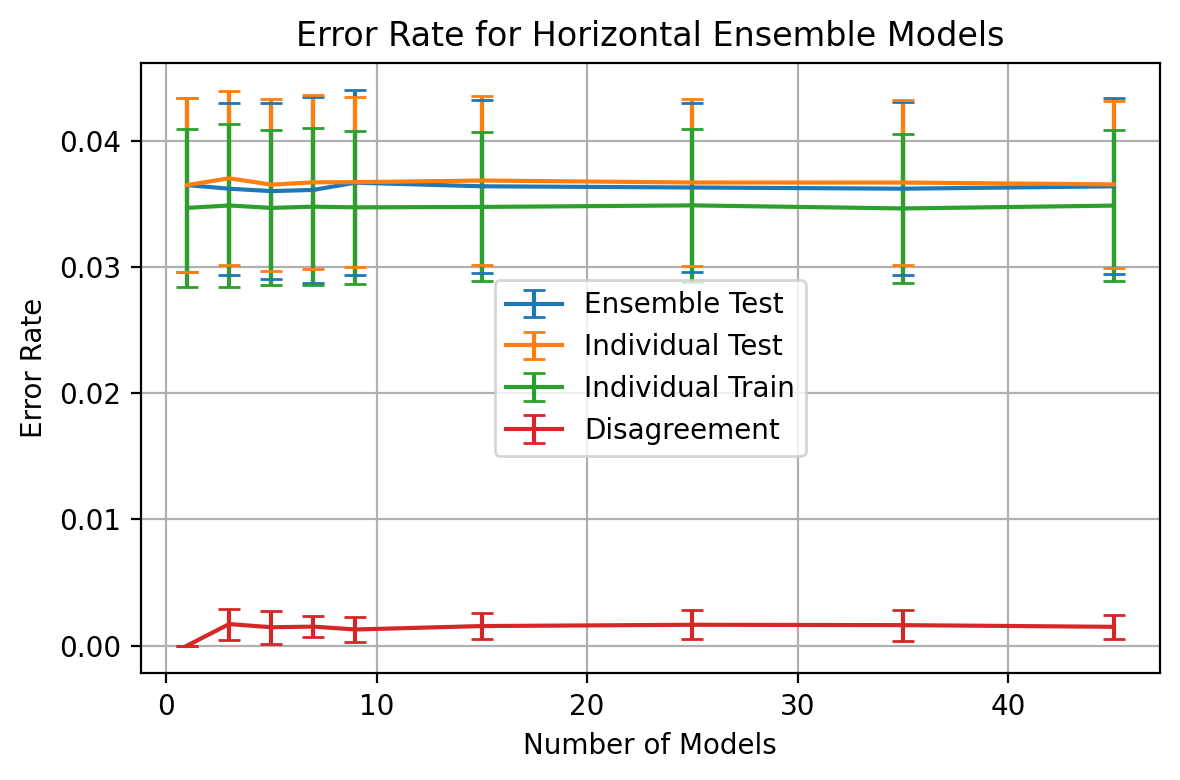

In [237]:
fig = plt.figure(figsize=(6, 4))
fig.set_dpi(fig_dpi)

# plt.plot(multi_ensem_models, 1 - mean_ensem_accuracy[0, :], 'x-', label='Ensemble Test')
# plt.plot(multi_ensem_models, 1 - mean_ensem_accuracy[2, :], 'x-', label='Individual Test')
# plt.plot(multi_ensem_models, 1 - mean_ensem_accuracy[1, :], 'x-', label='Individual Train')
# plt.plot(multi_ensem_models, 1 - mean_ensem_accuracy[3, :], 'x-', label='Agreement')

plt.errorbar(multi_ensem_models, 1 - mean_ensem_accuracy[0, :], yerr=std_ensem_accuracy[0, :], capsize=4, label='Ensemble Test')
plt.errorbar(multi_ensem_models, 1 - mean_ensem_accuracy[2, :], yerr=std_ensem_accuracy[2, :], capsize=4, label='Individual Test')
plt.errorbar(multi_ensem_models, 1 - mean_ensem_accuracy[1, :], yerr=std_ensem_accuracy[1, :], capsize=4, label='Individual Train')
plt.errorbar(multi_ensem_models, 1 - mean_ensem_accuracy[3, :], yerr=std_ensem_accuracy[3, :], capsize=4, label='Disagreement')

plt.title(f"Error Rate for Horizontal Ensemble Models")
# plt.ylim(0, 0.2)
# plt.ylim(0, np.max(1 - mean_ensem_accuracy + std_ensem_accuracy) + 0.05)
plt.grid()
plt.legend()
plt.xlabel("Number of Models")
plt.ylabel("Error Rate")

plt.tight_layout()
plt.savefig(f'graphs/{exp2_testname}-error-rate-curves.png')

plt.show()

# Experiment 3

Repeat Exp 2) for cancer dataset with two different optimisers of your choice e.g. 'trainlm' and 'trainrp'. Comment and discuss the result and decide which is more appropriate training algorithm for the problem. In your discussion, include in your description a detailed account of how the training algorithms (optimisations) work.

In [127]:
def evaluate_optimisers(optimizers=[(lambda: 'sgd', 'sgd'), 
                                    (lambda: 'adam', 'adam'), 
                                    (lambda: 'rmsprop', 'rmsprop')],
                        weight_init=lambda: 'glorot_uniform',
                        print_params=True,
                        **kwargs
                       ):
    for o in optimizers:
        
        if print_params:
            print(f'Optimiser: {o[1]}')
            
        yield list(evaluate_ensemble_vote(optimizer=o[0],
                                          weight_init=weight_init,
                                          exp=f'3-{o[1]}',
                                          print_params=print_params,
                                          **kwargs
                                         ))

## Single Iteration

In [13]:
single_optim_results = list()
for test in evaluate_optimisers(epochs=(5, 300), nmodels=[1, 3, 5]):
    single_optim_results.append(test)

Optimiser: sgd
Models: 1
Models: 3
Models: 5
Optimiser: adam
Models: 1
Models: 3
Models: 5
Optimiser: rmsprop
Models: 1
Models: 3
Models: 5


## Multiple Iterations

### Pickle Results

| test | optim1 | optim2 | optim3 | lr | momentum | epsilon | batch size | hidden nodes | epochs | models | stratified |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | SGD | Adam | RMSprop | 0.1 | 0.0 | 1e7 | 35 | 16 | 1 - 100 | 1, 3, 9, 15, 25 | y |
| 2 | SGD | Adam | RMSprop | 0.05 | 0.01 | 1e7 | 35 | 16 | 1 - 100 | 1, 3, 9, 15, 25 | y |
| 3 | SGD | Adam | RMSprop | 0.1 | 0.01 | 1e7 | 35 | 1 - 400 | 20 | 1, 3, 9, 15, 25, 35, 45 | y |
| 4 | SGD | Adam | RMSprop | 0.075 | 0.01 | 1e7 | 35 | 1 - 400 | 20 | 1, 3, 9, 15, 25, 35, 45 | y |
| 5 | SGD | Adam | RMSprop | 0.05 | 0.01 | 1e7 | 35 | 1 - 400 | 20 | 1, 3, 9, 15, 25, 35, 45 | n |
| 6 | SGD | Adam | RMSprop | 0.02 | 0.01 | 1e7 | 35 | m | 50 | 1, 3, 9, 15, 25, 35, 45 | n |
| 7 | SGD | Adam | RMSprop | 0.1 | 0.9 | 1e-8 | 35 | 1 - 400 | 50 - 100 | 1, 3, 5, 7, 9, 15, 25 | n |
| 8 | SGD | Adam | RMSprop | 0.05 | 0.9 | 1e-8 | 35 | 1 - 400 | 50 - 100 | 1, 3, 5, 7, 9, 15, 25 | n |

In [27]:
multi_optim_results = list()
multi_optim_iterations = 30

multi_optim_lr = 0.05
multi_optim_mom = 0.01
multi_optim_eps = 1e-07
multi_optims = [(lambda: tf_optim.SGD(learning_rate=multi_optim_lr, 
                                      momentum=multi_optim_mom), 'sgd'), 
                (lambda: tf_optim.Adam(learning_rate=multi_optim_lr, 
                                       epsilon=multi_optim_eps), 'adam'), 
                (lambda: tf_optim.RMSprop(learning_rate=multi_optim_lr, 
                                          momentum=multi_optim_mom, 
                                          epsilon=multi_optim_eps), 'rmsprop')]

for i in range(multi_optim_iterations):
    print(f"Iteration {i+1}/{multi_optim_iterations}")
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, 
#                                                                         stratify=labels
                                                                       )
    multi_optim_results.append(list(evaluate_optimisers(epochs=(50, 100),
                                                        hidden_nodes=(1, 400),
                                                        nmodels=[1, 3, 9, 15, 25],
                                                        optimizers=multi_optims,
                                                        weight_init=lambda: 'random_uniform',
                                                        batch_size=35,
                                                        dtrain=data_train, 
                                                        dtest=data_test, 
                                                        ltrain=labels_train, 
                                                        ltest=labels_test,
                                                        return_model=False,
                                                        print_params=False)))

Iteration 1/30
Iteration 2/30
Iteration 3/30
Iteration 4/30
Iteration 5/30
Iteration 6/30
Iteration 7/30
Iteration 8/30
Iteration 9/30
Iteration 10/30
Iteration 11/30
Iteration 12/30
Iteration 13/30
Iteration 14/30
Iteration 15/30
Iteration 16/30
Iteration 17/30
Iteration 18/30
Iteration 19/30
Iteration 20/30
Iteration 21/30
Iteration 22/30
Iteration 23/30
Iteration 24/30
Iteration 25/30
Iteration 26/30
Iteration 27/30
Iteration 28/30
Iteration 29/30
Iteration 30/30


### Accuracy Tensor

Create a tensor for holding the accuracy results

(Iterations x Param x Number of models)

#### Params
0. Test Accuracy
1. Train Accuracy
2. Individual Accuracy
3. Agreement

In [467]:
multi_optim_results_dict = dict() # indexed by optimiser name
multi_optim_iter = len(multi_optim_results) # number of iterations (30)

#####################################
## INDIVIDUAL RESULTS TO DICTIONARY
#####################################
for iter_idx, iteration in enumerate(multi_optim_results): # of 30 iterations
    for model_idx, model_test in enumerate(iteration): # of 3 optimisers
        for single_optim_test in model_test: # single tests for each optimisers
            
            single_optim_name = single_optim_test["optimizer"]["name"]
            if single_optim_name not in multi_optim_results_dict:
                multi_optim_results_dict[single_optim_name] = list(list() for _ in range(multi_optim_iter))

            multi_optim_results_dict[single_optim_name][iter_idx].append(single_optim_test)

# list of numbers of models used in test
multi_optim_models = sorted(list({i["num_models"] for i in multi_optim_results[0][0]}))

##################################
## DICTIONARY TO RESULTS TENSORS
##################################
optim_tensors = dict()
for optim, optim_results in multi_optim_results_dict.items():
    
    accuracy_optim_tensor = np.zeros((multi_optim_iter, 4, len(multi_optim_models)))
    for iter_idx, iteration in enumerate(optim_results):
        for single_test in iteration:

            optim_models_idx = multi_optim_models.index(single_test['num_models'])
            accuracy_optim_tensor[iter_idx, :, optim_models_idx] = test_tensor_data(single_test)
            
    optim_tensors[optim] = {
        "accuracy": accuracy_optim_tensor,
        "mean": np.mean(accuracy_optim_tensor, axis=0),
        "std": np.std(accuracy_optim_tensor, axis=0)
    }

print(f'{multi_optim_iter} Tests')
print(f'Optimisers: {list(multi_optim_results_dict.keys())}')
print(f'Models: {multi_optim_models}')
print()
print(f'Loss: {multi_optim_results[0][0][0]["loss"]}')

30 Tests
Optimisers: ['SGD', 'Adam', 'RMSprop']
Models: [1, 3, 5, 7, 9, 15, 25]

Loss: categorical_crossentropy


#### Export/Import Test Sets

Export mean and standard deviations for retrieval and visualisation 

In [28]:
pickle.dump(multi_optim_results, open("results/exp3-test5.p", "wb"))

In [466]:
exp3_testname = 'exp3-test8'
multi_optim_results = pickle.load(open(f"results/{exp3_testname}.p", "rb"))

### Best Results

In [468]:
for optim, optim_results in optim_tensors.items():
    best_optim_accuracy_idx = np.unravel_index(np.argmax(optim_results["mean"][0, :]), optim_results["mean"].shape)
    best_optim_accuracy = optim_results["mean"][best_optim_accuracy_idx]
    best_optim_accuracy_models = multi_optim_models[best_optim_accuracy_idx[1]]

    print(f'{optim}: {best_optim_accuracy_models} Models, {best_optim_accuracy * 100:.3}% Accurate')

SGD: 9 Models, 96.5% Accurate
Adam: 7 Models, 96.3% Accurate
RMSprop: 9 Models, 96.3% Accurate


### Optimiser Error Rates

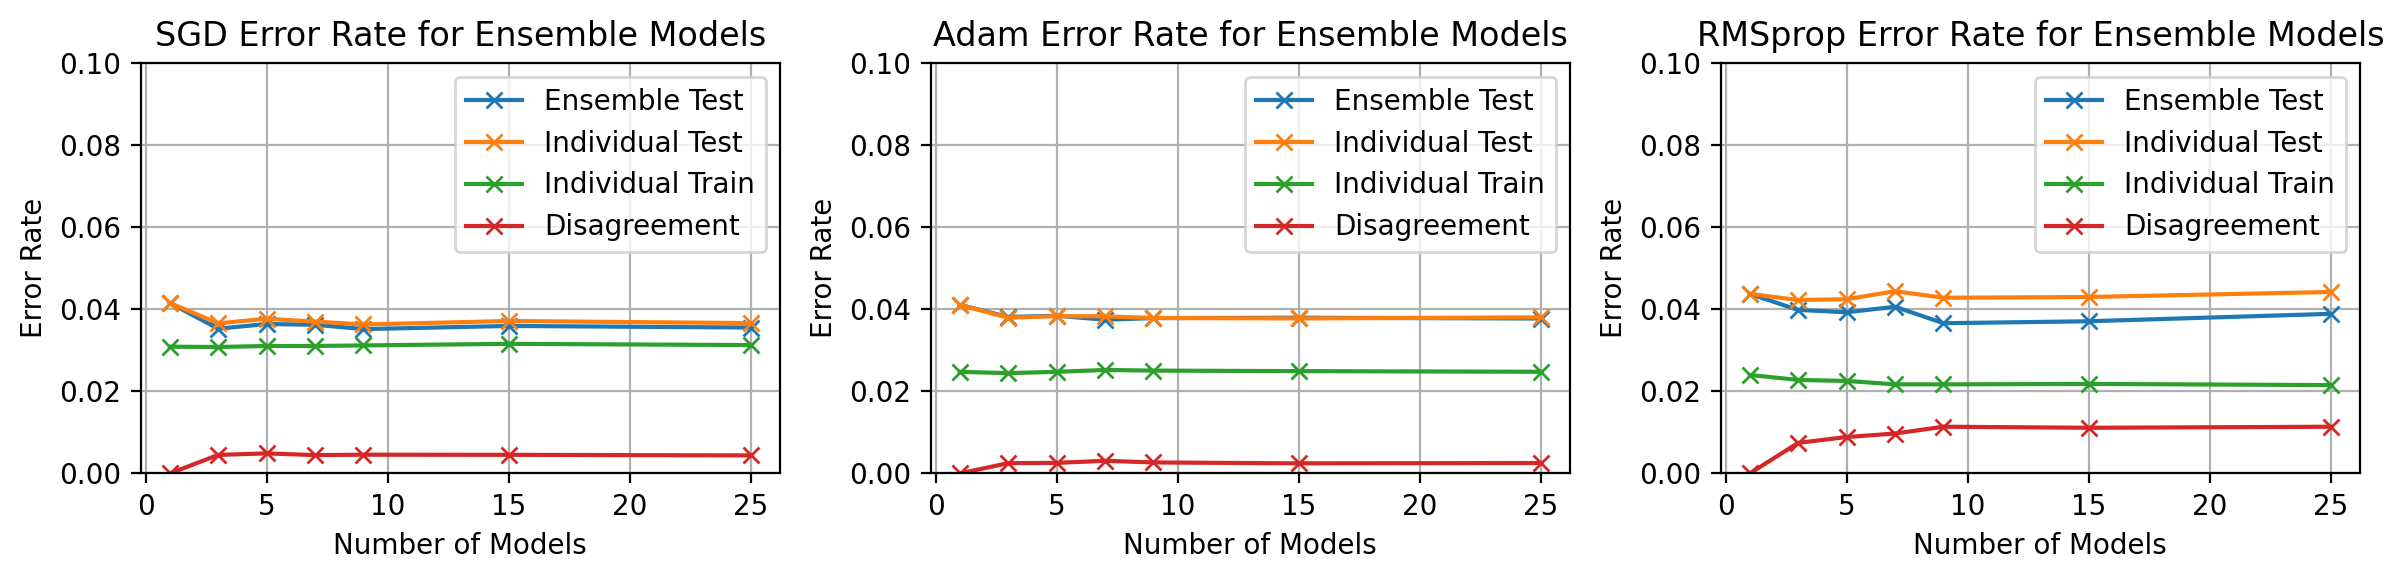

In [469]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.set_dpi(fig_dpi)

for idx, ((optimiser_name, tensors_dict), ax) in enumerate(zip(optim_tensors.items(), axes.flatten())):
    ax.plot(multi_optim_models, 1 - tensors_dict["mean"][0, :], 'x-', label='Ensemble Test')
    ax.plot(multi_optim_models, 1 - tensors_dict["mean"][2, :], 'x-', label='Individual Test')
    ax.plot(multi_optim_models, 1 - tensors_dict["mean"][1, :], 'x-', label='Individual Train')
    ax.plot(multi_optim_models, 1 - tensors_dict["mean"][3, :], 'x-', label='Disagreement')

#     ax.errorbar(multi_optim_models, 1 - tensors_dict["mean"][0, :], yerr=tensors_dict["std"][0, :], capsize=4, label='Ensemble Test')
#     ax.errorbar(multi_optim_models, 1 - tensors_dict["mean"][2, :], yerr=tensors_dict["std"][2, :], capsize=4, label='Individual Test')
#     ax.errorbar(multi_optim_models, 1 - tensors_dict["mean"][1, :], yerr=tensors_dict["std"][1, :], capsize=4, label='Individual Train')
#     ax.errorbar(multi_optim_models, 1 - tensors_dict["mean"][3, :], yerr=tensors_dict["std"][3, :], capsize=4, label='Disagreement')

    ax.set_title(f"{optimiser_name} Error Rate for Ensemble Models")
    ax.set_ylim(0, 0.1)
#     ax.set_ylim(0, np.max([np.max(1 - i["mean"] + i["std"]) for i in optim_tensors.values()]) + 0.03)
    ax.grid()
#     if idx > 0:
    ax.legend()
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("Error Rate")

# axes[0].set_ylim(0, 0.4)
axes[1].legend()
axes[2].legend()

plt.tight_layout()
plt.savefig(f'graphs/{exp3_testname}-error-rate-curves.png')

plt.show()